In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

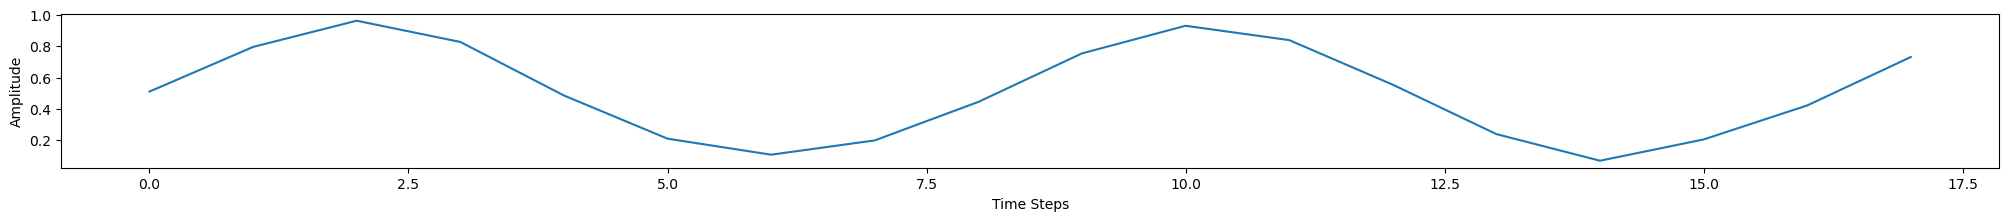

In [10]:
# plot some data
plt.figure(figsize=(25, 2))
for i in range(1):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
# plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
# plt.legend()
plt.show()